## Join the updated CDP netCDF with the updated CIP netCDF

The two netcdf files are joined on the CIP sample rate and a new netCDF is created

In [1]:
import xarray as xr
import math

In [2]:
def set_attrs(ds, var, name,unit,description, par_var=[], par_file="", instrument=""):
    # function to set standard attributes to new variables
    ds[var].attrs['name'] = name
    ds[var].attrs['unit'] = unit
    ds[var].attrs['description'] = description

    #optional arguments
    if par_var != "": ds[var].attrs['parent variables'] = par_var
    if par_file !="": ds[var].attrs['parent file'] = par_file
    if instrument !="": ds[var].attrs['instrument'] = instrument

    return ds

In [3]:
# function for joining TODO: move to separate file (Preprocessing)
def join_cdp_cip_ds(flight,sample_rate, cip_path, cdp_path):
    """ Joins the CIP and CDP netCDFs on CIP time

    Parameters
    ----------
    flight
        A string representing the flightid (islasid) of the files
    sample_rate
        the sample rate (in sek) to use for joining
    cip_path
        The path to where the CIP-netCDFs are located
    cdp_path
        The path to where the CDP-netCDFs are located
    save_path
        The path to where the joint-netCDF will be stored

    Returns
    -------
    microphy_ds
        An xarray with updated attributes of the joined CIP and CDP netCDF.
        Joined on sample time from the CIP netCDF file.
    """

    # Import packages
    import xarray as xr
    from datetime import date
    import glob
    import numpy as np

    # Import local functions
    import functions

    # read in data
    # TODO: handle more than one file for flight
    file1 = f'CIP_update_{sample_rate}s_{flight}.nc'

    cdp_file = glob.glob(cdp_path + f'CDP_updated_{flight}.nc')
    cip_file = glob.glob(cip_path + file1)

    print(f'Joining: {cdp_file[0]} and {cip_file[0]}')

    cdp_ds = xr.open_dataset(cdp_file[0])
    cip_ds = xr.open_dataset(cip_file[0])

    #  Remove milliseconds to ease joining
    cdp_ds = functions.floor_to_sec_res(cdp_ds, 'time')
    cip_ds = functions.floor_to_sec_res(cip_ds, 'time')

    # drop duplicate time steps 
    index = np.unique(cdp_ds.time, return_index = True)[1]
    cdp_ds = cdp_ds.isel(time=index)


    # merge the two xarrays on the times from cip.
    microphy_ds = xr.merge([cip_ds, cdp_ds],compat='override',join='left')
    
    # update attrs for variables with parent file
    for var_name in cdp_ds.data_vars:
        microphy_ds[var_name].attrs.update({"parent file":cdp_file[0].split('/')[-1]})
        microphy_ds[var_name].attrs.update({"instrument":"CDP"})
    for var_name in cip_ds.data_vars:
        microphy_ds[var_name].attrs.update({"parent file":cip_file[0].split('/')[-1]})
        microphy_ds[var_name].attrs.update({"instrument":"CIP"})
    
    # remove dataset attributes
    microphy_ds = microphy_ds.drop_attrs(deep = False)
    
    # set new dataset attributes
    microphy_ds.attrs['safireid']=cip_ds.attrs['safireid']
    microphy_ds.attrs['islasid']=cip_ds.attrs['islasid'] #NB! duplicated!
    microphy_ds.attrs['parent files']=[cip_file[0].split('/')[-1],cdp_file[0].split('/')[-1]]
    microphy_ds.attrs['date_modified'] = date.today().strftime("%Y-%m-%d")
    microphy_ds.attrs['Joint sample rate (sek)'] = cip_ds.attrs['RATE'] # Todo make check to use the largest value (should always be CIP though)
    

    # set the islas id as a coordinate
    islasid = cip_ds.attrs['islasid']
    microphy_ds = microphy_ds.assign_coords({'islasid':islasid})

    # close netcdf files
    cip_ds.close
    cdp_ds.close
    print('...done')

    return microphy_ds

In [5]:
# --- File paths

# main paths
main_path = '/home/ninalar/Documents/MC2'
cdp_path = main_path + '/Results_2022-islas/Processed/CDP_processed/'
cip_path = main_path + '/Results_2022-islas/Processed/CIP_processed/'
savepath = main_path + '/Results_2022-islas/Processed/ISLAS_processed/'

# sample rate to join on
sample_rate = 5

In [6]:
flights = ['IS22-02','IS22-03','IS22-04','IS22-05','IS22-06','IS22-07','IS22-08','IS22-09','IS22-10','IS22-11']

for flight in flights:
    print(flight)
    microphy_ds = join_cdp_cip_ds(flight,sample_rate,cip_path,cdp_path) # join the cdp and the cip file for the flight
    print(sample_rate)
    # create the derived cdp parameters
    microphy_ds = cdp_derived(microphy_ds)
    
    # write to netcdf file
    filename = f'microphy_{sample_rate}s_{flight}.nc'
    file_save_path = savepath + filename
    microphy_ds.to_netcdf(path=file_save_path, mode='w', encoding={'time':{'zlib':True}}, format = 'NETCDF4', engine='netcdf4')

IS22-02
Joining: /home/ninalar/Documents/MC2/Results_2022-islas/Processed/CDP_processed/CDP_updated_IS22-02.nc and /home/ninalar/Documents/MC2/Results_2022-islas/Processed/CIP_processed/CIP_update_5s_IS22-02.nc
...done
5
IS22-03
Joining: /home/ninalar/Documents/MC2/Results_2022-islas/Processed/CDP_processed/CDP_updated_IS22-03.nc and /home/ninalar/Documents/MC2/Results_2022-islas/Processed/CIP_processed/CIP_update_5s_IS22-03.nc
...done
5
IS22-04
Joining: /home/ninalar/Documents/MC2/Results_2022-islas/Processed/CDP_processed/CDP_updated_IS22-04.nc and /home/ninalar/Documents/MC2/Results_2022-islas/Processed/CIP_processed/CIP_update_5s_IS22-04.nc
...done
5
IS22-05
Joining: /home/ninalar/Documents/MC2/Results_2022-islas/Processed/CDP_processed/CDP_updated_IS22-05.nc and /home/ninalar/Documents/MC2/Results_2022-islas/Processed/CIP_processed/CIP_update_5s_IS22-05.nc
...done
5
IS22-06
Joining: /home/ninalar/Documents/MC2/Results_2022-islas/Processed/CDP_processed/CDP_updated_IS22-06.nc and /

In [17]:
# read in one file
path = '/home/ninalar/Documents/MC2/Results_2022-islas/Processed/ISLAS_processed/microphy_5s_IS22-07.nc'
ds = xr.open_dataset(path)


In [18]:
ds

<xarray.Dataset> Size: 8MB
Dimensions:                 (time: 2945, Vector64: 64, Vector40: 40, CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 24kB 2022-03-29T08:14:36 .....
    lat                     (time) float32 12kB ...
    lon                     (time) float32 12kB ...
    alt                     (time) float32 12kB ...
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    islasid                 <U7 28B ...
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/80)
    base_time               datetime64[ns] 8B ...
    utc_time                (time) float64 24kB ...
    TAS                     (time) float32 12kB ...
    MIDBINS                 (Vector64) float32 256B ...
    ACTIVETIME              (time) float32 12kB ...
    SA                      (Vector64) float32 256B ...
    ...                      ...
    CDP Bin Particle Count  (time, CDP_Bin) float64 707kB ...
    Mass                    (CDP_Bin) float64 240B ...
    Number Conc per bin     (time, CDP_Bin) float64 707kB ...
    Number Conc calc        (time) float64 24kB ...
    LWC per bin calc        (time, CDP_Bin) float64 707kB ...
    LWC calc                (time) float64 24kB ...
Attributes:
    safireid:                 as220011
    islasid:                  IS22-07
    parent files:             ['CIP_update_5s_IS22-07.nc', 'CDP_updated_IS22-...
    date_modified:            2025-10-27
    Joint sample rate (sek):  5.0

# Calculating the ED, LWC and NT manually

In [16]:
# Imports, prep and testing variables
import matplotlib.pyplot as plt
test_line = 9320

# read in one file
cdp_path = main_path + '/Results_2022-islas/Processed/CDP_processed/CDP_updated_IS22-11.nc'
ds = xr.open_dataset(cdp_path)

In [10]:
ds

<xarray.Dataset> Size: 7MB
Dimensions:                 (time: 14447, CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 116kB 2022-04-03T12:35:35.2...
    lat                     (time) float32 58kB ...
    lon                     (time) float32 58kB ...
    alt                     (time) float32 58kB ...
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
Data variables: (12/33)
    End Seconds             (time) float64 116kB ...
    Day of Year             (time) float64 116kB ...
    Year                    (time) float64 116kB ...
    Status                  (time) float64 116kB ...
    DOF Reject Counts       (time) float64 116kB ...
    Avg Transit Reject      (time) float64 116kB ...
    ...                      ...
    SV                      (time) float32 58kB ...
    Bin_min                 (CDP_Bin) int64 240B ...
    Size                    (CDP_Bin) int64 240B ...
    Threshold               (CDP_Bin) int64 240B ...
    Width                   (CDP_Bin) int64 240B ...
    CDP Bin Particle Count  (time, CDP_Bin) float64 3MB ...
Attributes: (12/32)
    description:                       Updated CDP data from a single flight ...
    safireid:                          as220015
    islasid:                           IS22-11
    source files:                      02CDP 20220403123534.csv
    PADS version:                      4.03.03
    CDP version:                       4.03.02
    ...                                ...
    GPS Time Source:                   0
    Channel Count:                     30
    Temperature Available:             FALSE
    GPS Available:                     FALSE
    Sample Time:                       1 sec (1 Hz)
    Housekeeping channel description:  The first 8 channels in the original d...

In [ ]:
# Calculating the ED manually (for particles larger than 6 mum)

# per bin calculate
radius = 0.5*ds['Size'] #size is in diameter, keep it in mum because I whant ED to end up as mum
# number of particlesper size bin is in ds['CDP Bin Particle Count']

radius3
radius2


<xarray.DataArray 'Size' (CDP_Bin: 30)> Size: 240B
array([ 1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,
        7. ,  8. ,  9. , 10. , 11. , 12. , 13. , 14. , 15. , 16. , 17. ,
       18. , 19. , 20. , 21. , 22. , 23. , 24. , 25. ])
Coordinates:
  * CDP_Bin  (CDP_Bin) int64 240B 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30

In [165]:
# calculate sample area: SA * TAS * Sample time
# mm^2 = 0.001^2*m^2
m = (0.001)**2
sa = float(ds.attrs['Sample Area (mm^2)'])*m
print(sa)
test = sa* ds['TAS']
test

2.69e-07


<xarray.DataArray 'TAS' (time: 14447)> Size: 58kB
array([1.8550847e-05, 1.8608654e-05, 1.8633142e-05, ..., 1.8169600e-05,
       1.8179177e-05, 1.8233073e-05], shape=(14447,), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 116kB 2022-04-03T12:35:35.265625 ... 2022-...
    lat      (time) float32 58kB ...
    lon      (time) float32 58kB ...
    alt      (time) float32 58kB ...

<function matplotlib.pyplot.show(close=None, block=None)>

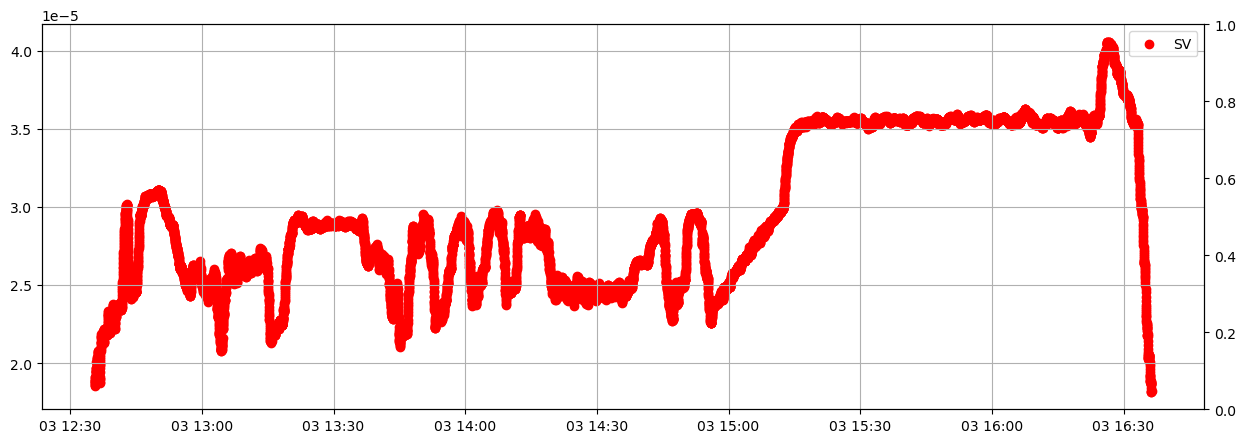

In [ ]:
fig, ax = plt.subplots(1,1, sharex=True,figsize=(15,5))

ax.scatter(test['time'], test, c ='r', label='SV') #changed form LWC calc
axt = ax.twinx()
ax.legend()
ax.grid(True)


plt.show


In [169]:
# Mass of individual droplet in bin = water density times volume of droplet. Size is the diameter of the droplet(largest size).

print(f'Size: {ds['Size'].attrs['unit']}')

ds['Mass']=(1000*4*math.pi/3)*(0.5*ds['Size']*1e-6)**3
ds = set_attrs(ds,'Mass',name = 'Mass of individual droplet in bin',unit = 'kg',
                description = 'Mass of Droplet, water density (1000 kg/m3) times volume of droplet',
                par_var = ['Size'],#par_file= cdp_file[0].split('/')[-1],
                instrument="CDP")

# 1000 is 1000 kg/m3

print(f'Mass one droplet per = 1000kg/m3*4*pi/3)*(0.5*Size*10**(-6)m)**3: {ds['Mass'].attrs['unit']}')

Size: um
Mass one droplet per = 1000kg/m3*4*pi/3)*(0.5*Size*10**(-6)m)**3: kg


In [ ]:
# total mass per bin per time (Particle count per bin times mass per bin)
#print(f'CDP particle count: unitless')
#print(f'Mass one droplet: {ds['Mass'].attrs['unit']}')


#ds['Mass Particle count'] = ds['CDP Bin Particle Count']*ds['Mass']
#ds = set_attrs(ds,'Mass Particle count',name = 'Total mass of water per bin',unit = 'kg',
#                description = 'Total mass, sum of mass of all droplets: Droplet mass X count of droplets',
#                par_var = ['CDP Bin Particle Count', 'Mass'],#par_file= cdp_file[0].split('/')[-1],
#                instrument="CDP")

#print(f'Total Mass per bin = Count per bin * Mass one droplet (kg): {ds['Mass Particle count'].attrs['unit']}')

CDP particle count: unitless
Mass: kg
Total Mass per bin = Count per bin * Mass one droplet (kg): kg


In [171]:
# Compute the number concentration in m-3 of each bin (counts per bin per sample volume)
print(f'CDP particle count: unitless')
print(f'SV: {ds['SV'].attrs['unit']}')


ds['Number Conc per bin']=ds['CDP Bin Particle Count']/ds['SV']
ds = set_attrs(ds, 'Number Conc per bin',name = 'Number concentration per bin',unit = '#/m3',
                description = 'Number concentration per bin. Counts per sample volume',
                par_var = ['CDP Bin Particle Count', 'SV'],#par_file= cdp_file[0].split('/')[-1],
                instrument="CDP")

print(f'Number concentration per bin = Count per bin / Sample volume (m^3): {ds['Number Conc per bin'].attrs['unit']}')



CDP particle count: unitless
SV: m^3
Number concentration per bin = Count per bin / Sample volume (m^3): #/m3


Number conc per bin: #/m3
LWC per bin = Total mass per bin (kg)* Number concentration per bin(#/m3) : kg/m3


ValueError: x and y must be the same size

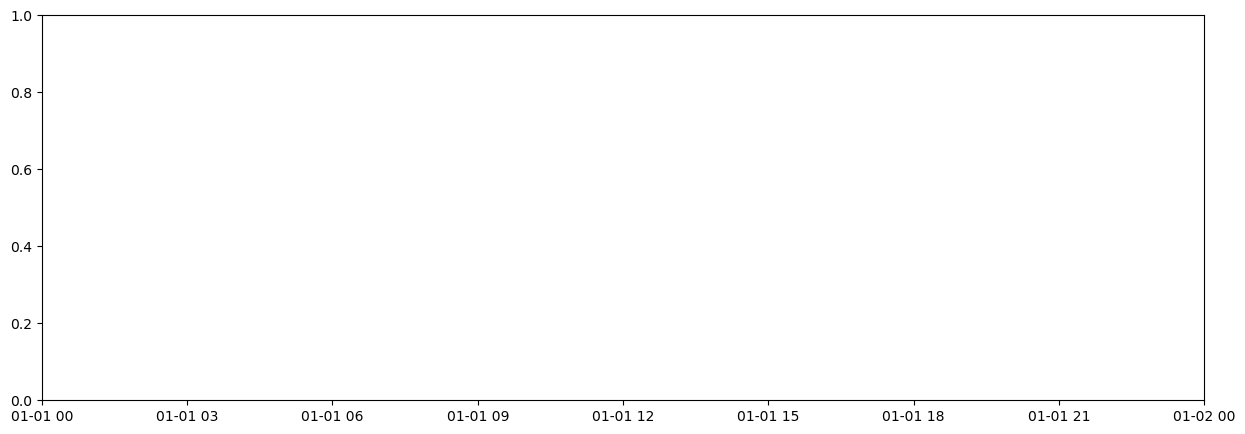

In [174]:
# calculate the LWC
#print(f'Total mass per bin: {ds['Mass Particle count'].attrs['unit']}')
print(f'Number conc per bin: {ds['Number Conc per bin'].attrs['unit']}')


ds['LWC per bin calc']=ds['Number Conc per bin']*ds['Mass']
ds = set_attrs(ds, 'LWC per bin calc',name = 'LWC per bin',unit= 'kg/m3',
            description= 'Liquid Water Content calculated from mass and number concentration, per bin',
            par_var= ['Mass Particle count', 'Number Conc per bin'], #par_file= cdp_file[0].split('/')[-1],
            instrument="CDP")

print(f'LWC per bin = Total mass per bin (kg)* Number concentration per bin(#/m3) : {ds['LWC per bin calc'].attrs['unit']}')


# --- Set up figure
fig, ax = plt.subplots(1,1, sharex=True,figsize=(15,5))

ax.scatter(ds['time'], ds['LWC per bin calc'], c ='r', label='CDP LWC') #changed form LWC calc
#ax[0].set_ylabel(f'LWC ({ds['LWC calc'].attrs['unit']})') #changed from LWC calc
ax.legend()
ax.grid(True)


plt.show


In [139]:
print(ds['LWC'].attrs['unit'])

g/m^3


Total LWC (above 6 um) in g = sum(LWC per bin)bins[6,:]


<function matplotlib.pyplot.show(close=None, block=None)>

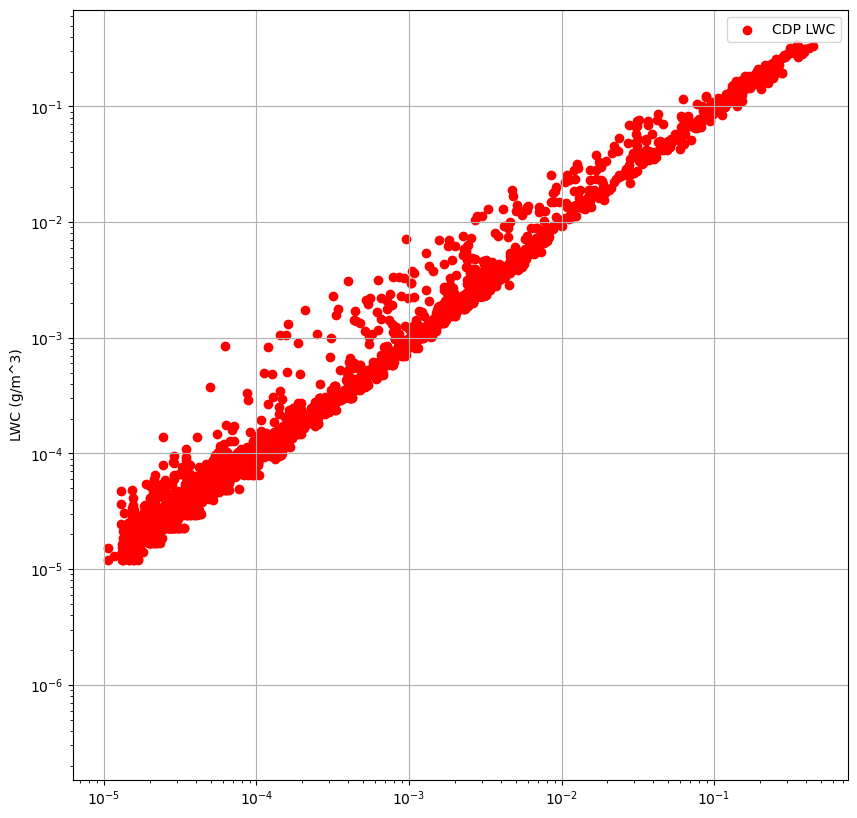

In [181]:

# calculate the LWC per time for bins higher than 6 mum
# multiply by 1000 to get g/m3
ds['LWC calc']= 1000*ds['LWC per bin calc'][:,6:].sum(dim='CDP_Bin')

ds = set_attrs(ds, 'LWC calc',name = 'LWC',unit= 'g/m3',
            description= 'Total Liquid Water Content for particles larger than 6 micrometers',
            par_var= ['LWC per bin calc'],#par_file= cdp_file[0].split('/')[-1],
            instrument="CDP")

print(f'Total LWC (above 6 um) in g = sum(LWC per bin)bins[6,:]')



# --- Set up figure
fig, ax = plt.subplots(1,1,figsize=(10,10))

#ax[0].scatter(ds['time'], ds['LWC calc'], c ='r', label='CDP LWC calc') #changed form LWC calc
#ax[0].set_ylabel(f'LWC ({ds['LWC calc'].attrs['unit']})') #changed from LWC calc
#ax[0].legend()
#ax[0].grid(True)

ax.scatter(ds['LWC calc'], ds['LWC'], c ='r', label='CDP LWC') #changed form LWC calc
ax.set_ylabel(f'LWC ({ds['LWC'].attrs['unit']})') #changed from LWC calc
ax.legend()
ax.grid(True)

ax.set_yscale('log')
ax.set_xscale('log')

plt.show




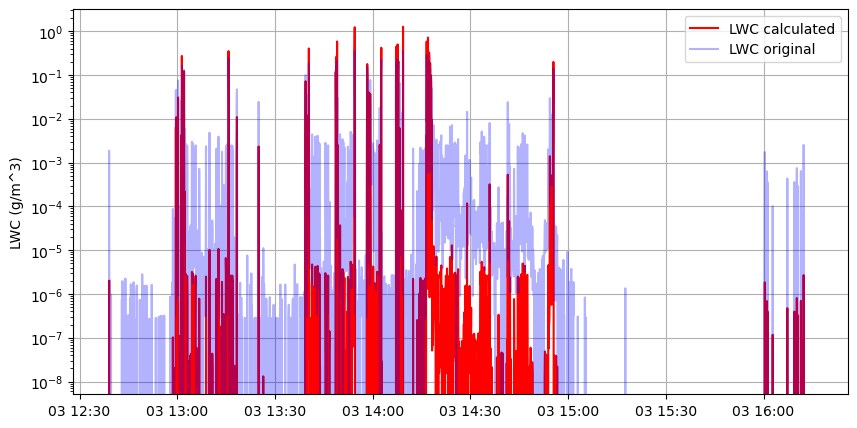

In [80]:

# plot LWC and NC differences vs tas and pas differences
import matplotlib.pyplot as plt

#single flight
flight='IS22-02'

mask = (microphy_ds['islasid']==flight).compute()
flight_ds=microphy_ds.where(mask, drop=True)


# --- Set up figure
fig, ax = plt.subplots(1,1, sharex=True,figsize=(10, 5))

#fig.suptitle(f'{flight} - {np.datetime64(flight_ds['time'][0].values,'D')} - (sample rate:{sample_rate}s)') # title for all figure: flightid and date

# WC plots
ax.plot(microphy_ds['time'], microphy_ds['LWC calc'], c ='r', label='LWC calculated')
ax.plot(microphy_ds['time'], microphy_ds['LWC corr'], c ='b',alpha=0.3, label='LWC original')
ax.set_ylabel(f'LWC ({flight_ds['LWC corr'].attrs['unit']})')
ax.legend()
ax.grid(True)

ax.set_yscale('log')



In [ ]:

# --- Set up figure
fig, ax = plt.subplots(1,1, sharex=True,figsize=(10, 5))

#fig.suptitle(f'{flight} - {np.datetime64(flight_ds['time'][0].values,'D')} - (sample rate:{sample_rate}s)') # title for all figure: flightid and date

# WC plots
ax.plot(microphy_ds['time'], microphy_ds['SV'], c ='r', label='LWC calculated')
ax.plot(microphy_ds['time'], microphy_ds['LWC corr'], c ='b',alpha=0.3, label='LWC original')
ax.set_ylabel(f'LWC ({flight_ds['LWC corr'].attrs['unit']})')
ax.legend()
ax.grid(True)

<xarray.Dataset> Size: 8MB
Dimensions:                 (time: 2597, Vector64: 64, Vector40: 40, CDP_Bin: 30)
Coordinates:
  * time                    (time) datetime64[ns] 21kB 2022-04-03T12:38:44 .....
    lat                     (time) float32 10kB ...
    lon                     (time) float32 10kB ...
    alt                     (time) float32 10kB ...
  * CDP_Bin                 (CDP_Bin) int64 240B 1 2 3 4 5 6 ... 26 27 28 29 30
    islasid                 <U7 28B 'IS22-11'
Dimensions without coordinates: Vector64, Vector40
Data variables: (12/82)
    base_time               datetime64[ns] 8B ...
    utc_time                (time) float64 21kB ...
    TAS                     (time) float32 10kB 83.0 82.0 81.0 ... 130.0 130.0
    MIDBINS                 (Vector64) float32 256B ...
    ACTIVETIME              (time) float32 10kB ...
    SA                      (Vector64) float32 256B ...
    ...                      ...
    Mass                    (CDP_Bin) float64 240B 1.414e-14 ... 6.545e-11
    Mass Particle count     (time, CDP_Bin) float64 623kB 0.0 0.0 ... 0.0 0.0
    Number Conc per bin     (time, CDP_Bin) float64 623kB 0.0 0.0 ... 0.0 0.0
    Number Conc calc        (time) float64 21kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    LWC per bin calc        (time, CDP_Bin) float64 623kB 0.0 0.0 ... 0.0 0.0
    LWC calc                (time) float64 21kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    safireid:                 as220015
    islasid:                  IS22-11
    parent files:             ['CIP_update_5s_IS22-11.nc', 'CDP_updated_IS22-...
    date_modified:            2025-10-24
    Joint sample rate (sek):  5.0

In [100]:
def cdp_derived(ds):

    # Mass of individual droplet in bin = water density times volume of droplet. Size is the diameter of the droplet(largest size).
    ds['Mass']=(1000*4*math.pi/3)*(0.5*ds['Size']*1e-6)**3

    # total mass per bin per time (Particle count per bin times mass per bin)
    ds['Mass Particle count'] = ds['CDP Bin Particle Count']*ds['Mass']

    # Compute the number concentration in m-3 of each bin (counts per bin per sample volume)
    ds['Number Conc per bin']=ds['CDP Bin Particle Count']/ds['SV']

    # Compute the total number concentration per time (sum of bin counts per sample volume) for bins larger than 6 mum
    ds['Number Conc calc']=(ds['CDP Bin Particle Count'][:,6:].sum(dim='CDP_Bin'))/ds['SV']
  
    # calculate the LWC
    ds['LWC per bin calc']=ds['Mass Particle count']*ds['Number Conc per bin'] 


    # calculate the LWC per time for bins higher than 6 mum
    ds['LWC calc']= ds['LWC per bin calc'][:,6:].sum(dim='CDP_Bin')
